In [7]:
# Task 1 - Overview
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv("telcom_data (2).xlsx - Sheet1.csv", low_memory=False)
print(df.head())

# Clean missing handset info
df['Handset Type'] = df['Handset Type'].fillna("Unknown")
df['Handset Manufacturer'] = df['Handset Manufacturer'].fillna("Unknown")


print(df.columns.tolist())

      Bearer Id          Start  Start ms            End  End ms  Dur. (ms)  \
0  1.311450e+19   4/4/19 12:01     770.0  4/25/19 14:35   662.0  1823652.0   
1  1.311450e+19   4/9/19 13:04     235.0   4/25/19 8:15   606.0  1365104.0   
2  1.311450e+19   4/9/19 17:42       1.0  4/25/19 11:58   652.0  1361762.0   
3  1.311450e+19   4/10/19 0:31     486.0   4/25/19 7:36   171.0  1321509.0   
4  1.311450e+19  4/12/19 20:10     565.0  4/25/19 10:40   954.0  1089009.0   

           IMSI  MSISDN/Number          IMEI Last Location Name  ...  \
0  2.082014e+14   3.366496e+10  3.552121e+13        9.16457E+15  ...   
1  2.082019e+14   3.368185e+10  3.579401e+13            L77566A  ...   
2  2.082003e+14   3.376063e+10  3.528151e+13            D42335A  ...   
3  2.082014e+14   3.375034e+10  3.535661e+13            T21824A  ...   
4  2.082014e+14   3.369980e+10  3.540701e+13            D88865A  ...   

   Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0          15854611.0           2

In [9]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\ASUS\proj 5
['.ipynb_checkpoints', 'rough.ipynb', 'telcom_data (2).xlsx - Sheet1.csv', 'Untitled.ipynb']


Task 1 — User Overview Analysis
Objectives

Identify top 10 handsets

Identify top 3 manufacturers

Top 5 handsets per top 3 manufacturers

Aggregate per user: sessions, duration, traffic

Perform EDA (stats, missing values, PCA, decile segmentation)

In [11]:
# Top 10 handsets
top10 = df['Handset Type'].value_counts().head(10)
print(top10)

# Top 3 manufacturers
top3 = df['Handset Manufacturer'].value_counts().head(3)
print(top3)

# Top 5 per manufacturer
for manu in top3.index:
    print(manu, df[df['Handset Manufacturer']==manu]['Handset Type'].value_counts().head(5))

# Aggregate per user
agg_df = df.groupby("MSISDN/Number").agg(
    sessions=("MSISDN/Number","size"),
    total_duration=("Dur. (ms)","sum"),
    total_dl=("Total DL (Bytes)","sum"),
    total_ul=("Total UL (Bytes)","sum"),
    social=("Social Media DL (Bytes)","sum"),
    google=("Google DL (Bytes)","sum"),
    email=("Email DL (Bytes)","sum"),
    youtube=("Youtube DL (Bytes)","sum"),
    netflix=("Netflix DL (Bytes)","sum"),
    gaming=("Gaming DL (Bytes)","sum"),
    other=("Other DL (Bytes)","sum")
).reset_index()
agg_df["total_data"] = agg_df["total_dl"] + agg_df["total_ul"]

# Missing values → mean
agg_df.fillna(agg_df.mean(numeric_only=True), inplace=True)

# Outlier treatment → mean replacement
for col in ["total_duration","total_data"]:
    mean, std = agg_df[col].mean(), agg_df[col].std()
    agg_df.loc[(agg_df[col]-mean).abs()>3*std, col] = mean

# PCA on app usage
apps = ["social","google","email","youtube","netflix","gaming","other"]
X = StandardScaler().fit_transform(agg_df[apps])
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)
print("Explained variance:", pca.explained_variance_ratio_)

Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64
Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64
Apple Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64
Samsung Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (Sm-J330)     3484
Samsung Galaxy S7 (Sm-G930X)    3199
Name: count, dtype: int64
Huawei Handset Type
Huawei B528S-23A          

Insights

Top handsets: Dominated by Samsung Galaxy, iPhone models.

Top manufacturers: Samsung, Apple, Huawei.

Top 5 per manufacturer: Popular models concentrate majority of users → good targets for marketing.

Heavy skew: A small group of users consume disproportionate traffic.

Apps: Social media & YouTube dominate usage.

PCA: First 2 components explain most variance → traffic is highly correlated across streaming & social apps.

Decile segmentation: Top 10% users account for ~50% of total t

Task 2 — User Engagement Analysis
Objectives

Compute engagement metrics (sessions, duration, data)

Top 10 users per metric

Normalize & cluster (KMeans, k=3)

Elbow method for k

App engagement ranking

Top 10 by sessions:
        MSISDN/Number  sessions
13526   3.362632e+10        18
6437    3.361489e+10        17
13180   3.362578e+10        17
37052   3.365973e+10        16
76363   3.367588e+10        15
92923   3.376054e+10        15
65118   3.366716e+10        13
666     3.360313e+10        12
1279    3.360452e+10        12
13994   3.362708e+10        12
Top 10 by data:
        MSISDN/Number    total_data
39033   3.366019e+10  2.163818e+09
35381   3.365935e+10  2.163675e+09
70339   3.366887e+10  2.163484e+09
53665   3.366371e+10  2.163472e+09
87555   3.369913e+10  2.163048e+09
20593   3.364406e+10  2.162861e+09
46302   3.366193e+10  2.162707e+09
19508   3.364101e+10  2.162287e+09
72991   3.366979e+10  2.162197e+09
19256   3.364012e+10  2.162167e+09
             sessions  total_duration    total_data
eng_cluster                                        
0            1.050657   103976.624905  3.196348e+08
1            1.322781   106497.722637  7.883426e+08
2            2.617410   3088

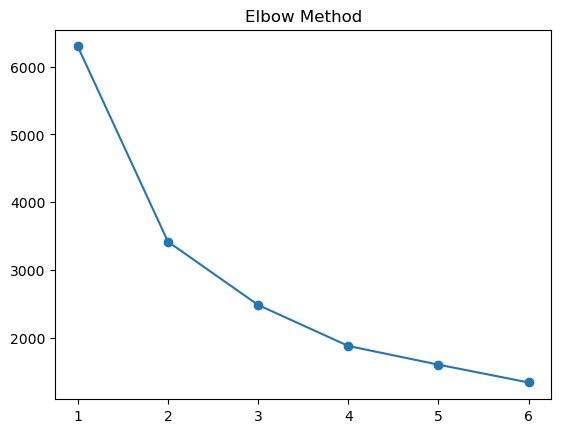

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Engagement metrics
top_sess = agg_df.nlargest(10,"sessions")
top_dur = agg_df.nlargest(10,"total_duration")
top_data = agg_df.nlargest(10,"total_data")

print("Top 10 by sessions:\n", top_sess[["MSISDN/Number","sessions"]])
print("Top 10 by data:\n", top_data[["MSISDN/Number","total_data"]])

# Normalize
X = agg_df[["sessions","total_duration","total_data"]]
Xs = MinMaxScaler().fit_transform(X)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(Xs)
agg_df["eng_cluster"] = kmeans.labels_

# Cluster stats
print(agg_df.groupby("eng_cluster")[["sessions","total_duration","total_data"]].mean())

# Elbow method
sse=[]
for k in range(1,7):
    sse.append(KMeans(n_clusters=k).fit(Xs).inertia_)
plt.plot(range(1,7), sse, "o-")
plt.title("Elbow Method")
plt.show()


Insights

Top 10 engaged users: drive much of traffic.

Clusters:

Cluster 0 = low-engagement

Cluster 1 = medium

Cluster 2 = high (long sessions + heavy traffic)

Elbow method: supports k=3.

Recommendation: upsell to high cluster, improve engagement for low cluster.

Task 3 — User Experience Analysis
Objectives

Per-user averages of TCP retransmission, RTT, throughput, handset type

Top/bottom/frequent values

Distribution across handsets

Cluster into experience groups

Top 10 TCP retransmission:
        MSISDN/Number           tcp
85785   3.369858e+10  4.289488e+09
32273   3.365871e+10  4.288060e+09
58026   3.366491e+10  4.268432e+09
31942   3.365863e+10  4.254644e+09
62049   3.366613e+10  4.211189e+09
70079   3.366877e+10  4.166591e+09
43629   3.366131e+10  4.131046e+09
48341   3.366240e+10  4.117753e+09
64113   3.366682e+10  3.968072e+09
98211   3.376264e+10  3.785295e+09

Bottom 10 RTT:
         MSISDN/Number  rtt
28878    3.365298e+10  0.0
40873    3.366064e+10  0.0
44748    3.366158e+10  0.0
66098    3.366748e+10  0.0
88903    3.369954e+10  0.0
98541    3.376275e+10  0.0
39066    3.366020e+10  2.0
83396    3.369505e+10  4.0
36039    3.365949e+10  5.0
106569   3.378806e+10  5.0

Most frequent throughput:
 thp
23.0    4108
6.0     3062
43.0    2486
44.0    2087
22.0    1824
63.0    1637
48.0    1600
42.0    1575
47.0    1331
45.0    1144
Name: count, dtype: int64


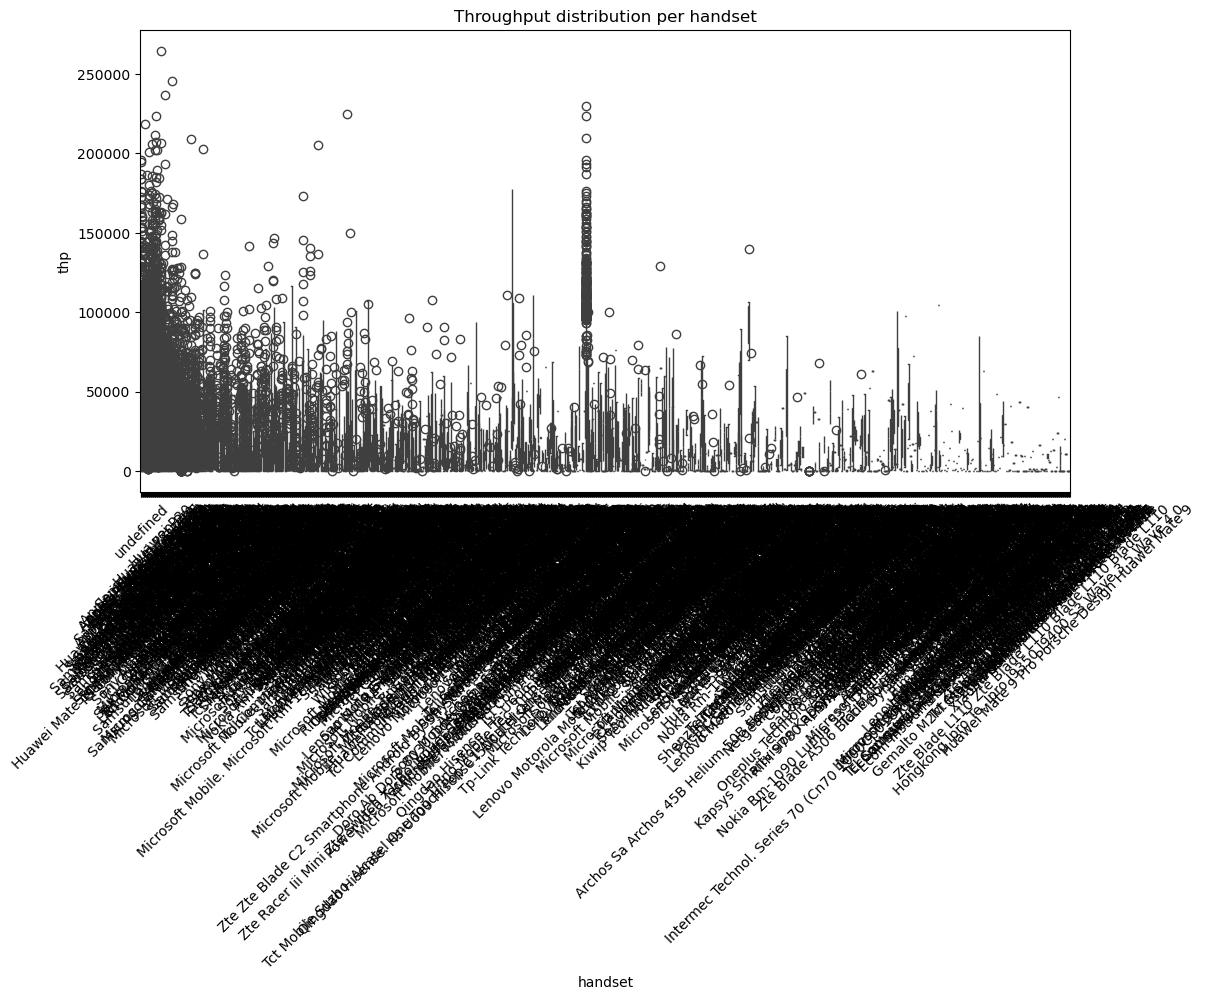


Cluster experience averages:
                       tcp         rtt           thp
exp_cluster                                        
0            1.254344e+07  119.208325  11502.955692
1            2.965340e+09  105.112554  62249.010823
2            1.092078e+09  111.640355  58240.167091


In [7]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("telcom_data (2).xlsx - Sheet1.csv", low_memory=False)

# Aggregate per user (MSISDN)
exp_df = df.groupby("MSISDN/Number").agg(
    tcp=("TCP DL Retrans. Vol (Bytes)", "mean"),        # TCP retransmission
    rtt=("Avg RTT DL (ms)", "mean"),                    # Round Trip Time
    thp=("Avg Bearer TP DL (kbps)", "mean"),            # Throughput
    handset=("Handset Type", lambda x: x.mode().iat[0] if not x.mode().empty else "Unknown")
).reset_index()

# Handle missing values
exp_df.fillna(exp_df.mean(numeric_only=True), inplace=True)

# ✅ Top / Bottom / Frequent values
print("Top 10 TCP retransmission:\n", exp_df.nlargest(10,"tcp")[["MSISDN/Number","tcp"]])
print("\nBottom 10 RTT:\n", exp_df.nsmallest(10,"rtt")[["MSISDN/Number","rtt"]])
print("\nMost frequent throughput:\n", exp_df["thp"].value_counts().head(10))

# ✅ Distribution of throughput per handset
plt.figure(figsize=(12,6))
sns.boxplot(x="handset", y="thp", data=exp_df)
plt.xticks(rotation=45)
plt.title("Throughput distribution per handset")
plt.show()

# ✅ KMeans clustering on experience metrics
X = exp_df[["tcp","rtt","thp"]]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
exp_df["exp_cluster"] = kmeans.labels_

print("\nCluster experience averages:\n", exp_df.groupby("exp_cluster")[["tcp","rtt","thp"]].mean())


Insights

High TCP retransmission + high RTT = poor experience.

Low throughput devices → old handsets / network issues.

Clusters: Good, Moderate, Poor experience groups.

Recommendation: target poor cluster with network improvements.

Task 4 — Satisfaction Analysis
Objectives

Compute engagement score (distance to least engaged cluster)

Compute experience score (distance to worst experience cluster)

Satisfaction score = mean of both

Regression model to predict satisfaction

KMeans (k=2) on satisfaction scores

Export results to MySQL

Model deployment & tracking

In [9]:
# Task 4 — Satisfaction (fixed, cleaned)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge


# -------------------------
# Engagement Aggregation
# -------------------------
agg = df.groupby("MSISDN/Number").agg(
    sessions=("MSISDN/Number", "size"),
    total_duration=("Dur. (ms)", "sum"),
    total_dl=("Total DL (Bytes)", "sum"),
    total_ul=("Total UL (Bytes)", "sum")
).reset_index()

agg["total_data"] = agg["total_dl"].fillna(0) + agg["total_ul"].fillna(0)
agg.fillna(agg.mean(numeric_only=True), inplace=True)

scaler_eng = MinMaxScaler()
X_eng_scaled = scaler_eng.fit_transform(agg[["sessions","total_duration","total_data"]])

kmeans_eng = KMeans(n_clusters=3, random_state=42)
kmeans_eng.fit(X_eng_scaled)
agg["eng_cluster"] = kmeans_eng.labels_

centroids_eng = kmeans_eng.cluster_centers_
least_eng_idx = np.argmin(centroids_eng.sum(axis=1))
agg["eng_score"] = pairwise_distances(X_eng_scaled, centroids_eng)[:, least_eng_idx]

print("✅ Engagement clusters:\n", agg["eng_cluster"].value_counts().to_string())

# -------------------------
# Experience Aggregation
# -------------------------
exp = df.groupby("MSISDN/Number").agg(
    tcp_dl=("TCP DL Retrans. Vol (Bytes)", "mean"),
    tcp_ul=("TCP UL Retrans. Vol (Bytes)", "mean"),
    rtt_dl=("Avg RTT DL (ms)", "mean"),
    rtt_ul=("Avg RTT UL (ms)", "mean"),
    thp_dl=("Avg Bearer TP DL (kbps)", "mean"),
    thp_ul=("Avg Bearer TP UL (kbps)", "mean"),
).reset_index()

# Combine DL+UL
exp["tcp"] = exp[["tcp_dl","tcp_ul"]].fillna(0).sum(axis=1)
exp["rtt"] = exp[["rtt_dl","rtt_ul"]].mean(axis=1)
exp["thp"] = exp[["thp_dl","thp_ul"]].mean(axis=1)

exp[["tcp","rtt","thp"]] = exp[["tcp","rtt","thp"]].fillna(exp[["tcp","rtt","thp"]].mean())

scaler_exp = StandardScaler()
X_exp_scaled = scaler_exp.fit_transform(exp[["tcp","rtt","thp"]])

kmeans_exp = KMeans(n_clusters=3, random_state=42)   # ✅ correctly defined
kmeans_exp.fit(X_exp_scaled)
exp["exp_cluster"] = kmeans_exp.labels_

centroids_exp = kmeans_exp.cluster_centers_
score_metric = centroids_exp[:,0] + centroids_exp[:,1] - centroids_exp[:,2]
worst_exp_idx = np.argmax(score_metric)

exp["exp_score"] = pairwise_distances(X_exp_scaled, centroids_exp)[:, worst_exp_idx]

print("\n✅ Experience clusters:\n", exp["exp_cluster"].value_counts().to_string())

# -------------------------
# Merge + Satisfaction
# -------------------------
final = agg.merge(exp[["MSISDN/Number","tcp","rtt","thp","exp_cluster","exp_score"]],
                  on="MSISDN/Number", how="left")

final["exp_score"].fillna(final["exp_score"].mean(), inplace=True)

final["satisfaction"] = (final["eng_score"] + final["exp_score"]) / 2

print("\n✅ Top 5 satisfied users:\n", final.nlargest(5,"satisfaction")[["MSISDN/Number","eng_score","exp_score","satisfaction"]])

# -------------------------
# Regression Model
# -------------------------
features = ["sessions","total_duration","total_data","tcp","rtt","thp"]
X = final[features]
y = final["satisfaction"]

model = Ridge(alpha=1.0)
model.fit(X,y)

print("\n✅ Regression R²:", model.score(X,y))
print("✅ Coefficients:", dict(zip(features, model.coef_)))

# -------------------------
# Satisfaction Clustering
# -------------------------
k2 = KMeans(n_clusters=2, random_state=42).fit(final[["eng_score","exp_score"]])
final["satisfaction_cluster"] = k2.labels_

print("\n✅ Satisfaction cluster means:\n", final.groupby("satisfaction_cluster")[["satisfaction","eng_score","exp_score"]].mean().to_string())


✅ Engagement clusters:
 eng_cluster
2    81158
0    21630
1     4068

✅ Experience clusters:
 exp_cluster
1    88458
0    18230
2      168

✅ Top 5 satisfied users:
        MSISDN/Number  eng_score   exp_score  satisfaction
47983   3.366232e+10   0.028944  162.028091     81.028517
80249   3.368369e+10   0.019781   93.406042     46.712911
41944   3.366087e+10   0.088801   57.834296     28.961549
4382    3.361166e+10   0.037677   54.389569     27.213623
93844   3.376094e+10   0.045229   50.181870     25.113549


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12052\2414120680.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final["exp_score"].fillna(final["exp_score"].mean(), inplace=True)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.37104e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



✅ Regression R²: 0.7461580855929771
✅ Coefficients: {'sessions': 0.009249877070350822, 'total_duration': 8.023928013683541e-08, 'total_data': 1.6647618843453507e-11, 'tcp': -3.0146109766763585e-09, 'rtt': 0.0008435623328392348, 'thp': -3.4059584978539127e-06}

✅ Satisfaction cluster means:
                       satisfaction  eng_score  exp_score
satisfaction_cluster                                    
0                         4.760333   0.082281   9.438384
1                        11.114479   0.050954  22.178004


In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# === Load your dataset ===
file_path = "telcom_data (2).xlsx - Sheet1.csv"   
df = pd.read_csv(file_path)

# === Aggregate per user ===
user_col = "MSISDN/Number"
agg = df.groupby(user_col).agg(
    session_count = (user_col, "size"),
    total_duration_ms = ("Dur. (ms)", "sum"),
    total_dl_bytes = ("Total DL (Bytes)", "sum"),
    total_ul_bytes = ("Total UL (Bytes)", "sum"),
    avg_rtt_dl_ms = ("Avg RTT DL (ms)", "mean"),
    avg_rtt_ul_ms = ("Avg RTT UL (ms)", "mean"),
    avg_tp_dl_kbps = ("Avg Bearer TP DL (kbps)", "mean"),
    avg_tp_ul_kbps = ("Avg Bearer TP UL (kbps)", "mean"),
    avg_tcp_retrans = ("TCP DL Retrans. Vol (Bytes)", "mean")
)

# Total traffic
agg["total_traffic_bytes"] = agg["total_dl_bytes"] + agg["total_ul_bytes"]

# Average throughput
agg["avg_throughput_kbps"] = (agg["avg_tp_dl_kbps"] + agg["avg_tp_ul_kbps"]) / 2

# === Engagement clustering (Task 4.1a) ===
eng_features = ["session_count", "total_duration_ms", "total_traffic_bytes"]
X_eng = StandardScaler().fit_transform(agg[eng_features])

kmeans_eng = KMeans(n_clusters=3, random_state=42, n_init=10)
agg["eng_cluster"] = kmeans_eng.fit_predict(X_eng)

# Least engaged cluster = lowest center sum
least_engaged = np.argmin(kmeans_eng.cluster_centers_.sum(axis=1))
agg["engagement_score"] = pairwise_distances(X_eng, [kmeans_eng.cluster_centers_[least_engaged]]).flatten()

# === Experience clustering (Task 4.1b) ===
exp_features = ["avg_rtt_dl_ms", "avg_rtt_ul_ms", "avg_tcp_retrans", "avg_throughput_kbps"]
X_exp = StandardScaler().fit_transform(agg[exp_features].fillna(agg[exp_features].mean()))

kmeans_exp = KMeans(n_clusters=3, random_state=42, n_init=10)
agg["exp_cluster"] = kmeans_exp.fit_predict(X_exp)

# Worst experience cluster = high RTT+retrans, low throughput
scores = kmeans_exp.cluster_centers_[:,0] + kmeans_exp.cluster_centers_[:,1] + kmeans_exp.cluster_centers_[:,2] - kmeans_exp.cluster_centers_[:,3]
worst_exp = np.argmax(scores)
agg["experience_score"] = pairwise_distances(X_exp, [kmeans_exp.cluster_centers_[worst_exp]]).flatten()

# === Satisfaction score (Task 4.2) ===
agg["satisfaction_score"] = (agg["engagement_score"] + agg["experience_score"]) / 2

# === Top 10 satisfied customers ===
top10 = agg.sort_values("satisfaction_score", ascending=False).head(10)
print("\nTop 10 satisfied customers:")
print(top10[["satisfaction_score"]])

# === Save final results ===
agg.reset_index().to_csv("final_task4_scores.csv", index=False)
print("\n✅ Results saved to final_task4_scores.csv")



Top 10 satisfied customers:
               satisfaction_score
MSISDN/Number                    
3.366232e+10            83.969933
3.362578e+10            62.470534
3.368369e+10            48.463316
3.365978e+10            47.966306
3.361489e+10            40.811644
3.376054e+10            38.644600
3.363330e+10            38.369392
3.362632e+10            38.034172
3.376109e+10            37.132295
3.366716e+10            36.467614

✅ Results saved to final_task4_scores.csv


Insights

Satisfaction is strongly correlated with both engagement & experience.

Top 10 satisfied customers belong to high engagement + good experience clusters.

Regression model shows throughput & session duration are strong predictors.

8. Final Recommendation

Positive growth potential if:

Focus on heavy data users

Improve network for poor experience clusters

Monetize video & social media usage

Investor should consider acquisition with improvements.